# Deterministic Goldstein-Taylor equation
---
Consider the equation
$$
\left\{
\begin{aligned}
&\frac{\partial u}{\partial t} + \frac{\partial v}{\partial x} = 0, \\
&\frac{\partial v}{\partial t} + \frac{1}{\epsilon}\frac{\partial u}{\partial x} = - \frac{1}{\epsilon}v, 
\end{aligned}
\right.
$$
where $\epsilon$ is a small number.

The initial data are
$$
\left\{
\begin{aligned}
&u(x, 0) = 2, v(x, 0) = 0, x\in [-1, 0], \\
&u(x, 0) = 1, v(x, 0) = 0, x\in (0, 1],
\end{aligned}
\right.
$$

BC:
$$
u(-1, t) = 2, \ v(-1, t) = 0, \ u(1, t) = 1, \ v(1, t) = 0.
$$

The spatiotemporal domain is 
$$
(x, t) \in [-1, 1]\times [0, 0.25].
$$

In [1]:
NAME = "2_0.01"

In [2]:
import jax, jax.nn
from jax import random
import jax.numpy as jnp
from jax.experimental import optimizers
from jax.ops import index, index_add, index_update


import sys, os
sys.path.append("../../")
	
from Seismic_wave_inversion_PINN.data_utils import *
from Seismic_wave_inversion_PINN.jax_model import *

from collections import namedtuple
# from jax.config import config; config.update("jax_enable_x64", True)
# dtype = jnp.float64
dtype = jnp.float32

In [3]:
key = random.PRNGKey(1)
key, subkey = random.split(key, 2)

layers = [2] + [32]*8 + [2] # (x, t) -> (u, v)
c0 = 10.0
w0 = jnp.array([[10.0, 10.0]]).T
w1 = jnp.array([[1.0, 1.0]]) # (w_u, w_v)
direct_params = init_siren_params(subkey, layers, c0, w0, w1, dtype)

domain = jnp.array([[-1., 0.], [1., 0.25]])
spatial_width = domain[1, 0]-domain[0, 0]

epsilon = 0.01

@jax.jit
def model(params, xt): # for predictions
	for w, b in params[:-1]:
		xt = jnp.sin(jnp.dot(xt, w) + b)
	return jnp.dot(xt, params[-1][0]) + params[-1][1]

# @jax.jit
# def model_(params, xt): # for derivatives
# 	for w, b in params[:-1]:
# 		xt = jnp.sin(jnp.dot(xt, w) + b)
# 	return jnp.dot(xt, params[-1][0]) + params[-1][1]

jacobian = jacrev_fn(model)
hessian = hessian_fn(model)

In [4]:
metaloss = mae

# static_jit = lambda i: jax.partial(jax.jit, static_argnums = i)

# jacobian[i] = [[du/dx, du/dt],
#                [dv/dx, dv/dt]]
# i: the i^th input

# hessian[i] = [
#				[[du/dxx, du/dxy],
#                [du/dxy, du/dyy]],
#               [[dv/dxx, dv/dxy],
#                [dv/dxy, dv/dyy]]
#              ]
@jax.jit
def loss_fn_(params, batch):
	collocation, dirichlet = batch["collocation"], batch["dirichlet"]
	direct_params = params
	
	if collocation[0] is not None:
		uv_c = model(direct_params, jnp.hstack([collocation.x, collocation.t]))
		u_c, v_c = uv_c[:, 0:1], uv_c[:, 1:2]
		duv_dxt_c = jacobian(direct_params, jnp.hstack([collocation.x, collocation.t]))
		du_dt_c, dv_dt_c = duv_dxt_c[:, 0:1, 1], duv_dxt_c[:, 1:2, 1]
		du_dx_c, dv_dx_c = duv_dxt_c[:, 0:1, 0], duv_dxt_c[:, 1:2, 0]
		loss_c1 = metaloss(du_dt_c + dv_dx_c, 0)
		loss_c2 = metaloss(dv_dt_c + 1/epsilon*du_dx_c, -1/epsilon*v_c)
		loss_c = loss_c1 + loss_c2
	else:
		loss_c = 0.0
        
	if dirichlet[0] is not None:
		uv_d = model(direct_params, jnp.hstack([dirichlet.x, dirichlet.t]))
		u_d, v_d = uv_d[:, 0:1], uv_d[:, 1:2]
		loss_d1 = metaloss(u_d, dirichlet.u)
		loss_d2 = metaloss(v_d, dirichlet.v)
		loss_d = loss_d1 + loss_d2
	else:
		loss_d = 0.0

	return loss_c, loss_d

@jax.jit
def loss_fn(params, batch):
	w = batch["weights"]
	loss_c, loss_d = loss_fn_(params, batch)
	return w["c"]*loss_c + w["d"]*loss_d + l1_regularization(params, w["l1"]) + l2_regularization(params, w["l2"])

@jax.jit
def step(i, opt_state, batch):
	params = get_params(opt_state)
	grad = jax.grad(loss_fn, 0)(params, batch)
	return opt_update(i, grad, opt_state)

@jax.jit
def evaluate(params, batch):
	w = batch["weights"]
	loss_c, loss_d = loss_fn_(params, batch)
	l1 = l1_regularization(params, 1.0)
	l2 = l2_regularization(params, 1.0)
	return w["c"]*loss_c + w["d"]*loss_d, loss_c, loss_d, l1, l2

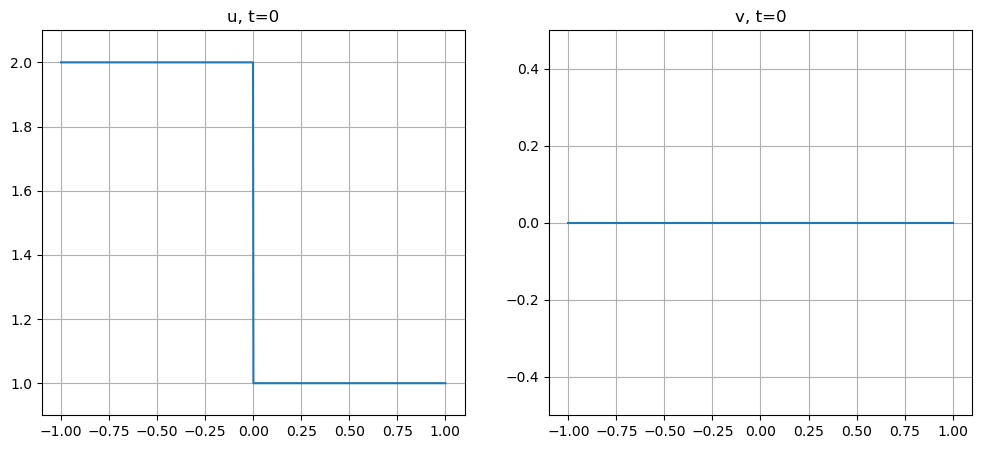

In [5]:
u0_fn = lambda x, t: jnp.select([x <= 0, x > 0], [2.0, 1.0])
v0_fn = lambda x, t: jnp.zeros_like(x)

u0_fn_ = lambda xt: jnp.select([xt[0] < 0, xt[0] > 0], [2.0, 1.0])
v0_fn_ = lambda xt: jnp.zeros_like(xt[0])

du0_dt_fn = lambda xt: jax.vmap(jax.jacfwd(u0_fn_), in_axes = 0)(xt)[:, 1:2]
dv0_dt_fn = lambda xt: jax.vmap(jax.jacfwd(v0_fn_), in_axes = 0)(xt)[:, 1:2]

du0_dx_fn = lambda xt: jax.vmap(jax.jacfwd(u0_fn_), in_axes = 0)(xt)[:, 0:1]
dv0_dx_fn = lambda xt: jax.vmap(jax.jacfwd(v0_fn_), in_axes = 0)(xt)[:, 0:1]

x0 = np.linspace(*domain[:, 0], 1000)
t0 = np.zeros_like(x0)
u0 = u0_fn(x0, t0)
v0 = v0_fn(x0, t0)

import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)

f, ax = plt.subplots(1, 2, figsize = (12, 5))
ax[0].plot(x0, u0)
ax[0].set_title("u, t=0")
ax[0].grid()
ax[0].set_ylim([0.9, 2.1])
ax[1].plot(x0, v0)
ax[1].set_title("v, t=0")
ax[1].grid()
ax[1].set_ylim([-0.5, 0.5])
plt.show()

key, *subkeys = random.split(key, 3)

n_i = 2000
x_i = jnp.linspace(*domain[:, 0], n_i).reshape((-1, 1))
t_i = jnp.zeros_like(x_i)
u_i = u0_fn(x_i, t_i)
v_i = v0_fn(x_i, t_i)

n_b = 2000
x_bl = jnp.ones((n_b, 1))*domain[0, 0]
x_br = jnp.ones((n_b, 1))*domain[1, 0]
t_b = jnp.linspace(*domain[:, 1], n_b).reshape((-1, 1))
x_b = jnp.vstack([x_bl, x_br])
t_b = jnp.vstack([t_b, t_b])
u_b = u0_fn(x_b, t_b)
v_b = v0_fn(x_b, t_b)

n_cx = 1000
n_ct = 1000
x_c = jnp.linspace(*domain[:, 0], n_cx).reshape((-1, 1))
t_c = jnp.linspace(*domain[:, 1], n_ct).reshape((-1, 1))
xt_c = tensor_grid([x_c, t_c])

dataset_Dirichlet = namedtuple("dataset_Dirichlet", ["x", "t", "u", "v"])
dataset_Collocation = namedtuple("dataset_Collocation", ["x", "t"])

dirichlet = dataset_Dirichlet(jnp.vstack([x_i, x_b]), jnp.vstack([t_i, t_b]), jnp.vstack([u_i, u_b]), jnp.vstack([v_i, v_b]))
collocation = dataset_Collocation(xt_c[:, 0:1], xt_c[:, 1:2])

In [6]:
# class Time_Marching_Generator:
# 	def __init__(self, key, spatial_points, temporal_domain, batch_size, iterations, update_every, count1 = 0):
# 		self.key = key
# 		self.spatial_points = spatial_points
# 		self.domain = temporal_domain
# 		self.batch_size = batch_size
# 		self.iterations = iterations
# 		self._count1 = count1
# 		self._count2 = update_every
# 		if count1 < iterations:
# 			self._update(self.domain[0])
# 		else:
# 			self._update(self.domain[1])
# 		self.update_every = update_every
		
# 	def _update(self, tmax):
# 		self.key, subkey = random.split(self.key)
# 		self._t = random.uniform(key, (self.batch_size, 1), jnp.float32, self.domain[0], tmax)
		
# 	def __iter__(self):
# 		return self
	
# 	def __next__(self):
# 		if self._count2 == self.update_every:
# 			self._count1 = max(self.iterations, self._count1 + 1)
# 			tmax = self.domain[0] + (self.domain[1]-self.domain[0])*self._count1/self.iterations
# 			self._update(tmax)
# 			self._count2 = 0
# 		else:
# 			self._count2 += 1
# 		return self.spatial_points, self._t

In [7]:
lr = 1e-4
params = direct_params
opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(params)
hist = {"iter": [], "loss": []}

batch_size = {"dirichlet": 2000, "collocation": 100000}
key, *subkeys = random.split(key, 5)
Dirichlet = Batch_Generator(subkeys[0], dirichlet, batch_size["dirichlet"])
Collocation = Batch_Generator(subkeys[1], collocation, batch_size["collocation"])

start_iteration = 0
iterations = 100000
print_every = 500
save_every = 10000
weights = {"c": 1.0, "d": 100.0, "l1": 1e-8, "l2": 1e-8}

for iteration in range(start_iteration, start_iteration+iterations+1):
	batch = {
		"dirichlet": dataset_Dirichlet(*next(Dirichlet)),
		"collocation": dataset_Collocation(*next(Collocation)),
		"weights": weights,
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d", "l1_reg", "l2_reg"]
		params_ = get_params(opt_state)
		batch = {
			"dirichlet": dataset_Dirichlet(*Dirichlet.dataset),
			"collocation": dataset_Collocation(*Collocation.dataset),
			"weights": weights
		}
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/21, 17:58:17, Iteration: 0, Train Loss: 7.9777e+03, c: 7.7044e+03, d: 2.7333e+00, l1_reg: 2.7167e+03, l2_reg: 1.1380e+04
2020/08/21, 17:58:25, Iteration: 500, Train Loss: 1.4710e+03, c: 1.3350e+03, d: 1.3600e+00, l1_reg: 2.6527e+03, l2_reg: 1.1326e+04
2020/08/21, 17:58:34, Iteration: 1000, Train Loss: 6.5187e+02, c: 5.4959e+02, d: 1.0228e+00, l1_reg: 2.6097e+03, l2_reg: 1.1288e+04
2020/08/21, 17:58:42, Iteration: 1500, Train Loss: 3.6099e+02, c: 2.7980e+02, d: 8.1192e-01, l1_reg: 2.5779e+03, l2_reg: 1.1259e+04
2020/08/21, 17:58:51, Iteration: 2000, Train Loss: 2.2528e+02, c: 1.6260e+02, d: 6.2675e-01, l1_reg: 2.5523e+03, l2_reg: 1.1237e+04
2020/08/21, 17:59:00, Iteration: 2500, Train Loss: 1.5095e+02, c: 9.9272e+01, d: 5.1674e-01, l1_reg: 2.5311e+03, l2_reg: 1.1218e+04
2020/08/21, 17:59:09, Iteration: 3000, Train Loss: 1.1114e+02, c: 6.2678e+01, d: 4.8462e-01, l1_reg: 2.5133e+03, l2_reg: 1.1202e+04
2020/08/21, 17:59:18, Iteration: 3500, Train Loss: 8.8796e+01, c: 4.1357e+01, d:

2020/08/21, 18:07:36, Iteration: 31000, Train Loss: 4.5536e+00, c: 3.6813e+00, d: 8.7234e-03, l1_reg: 2.3591e+03, l2_reg: 1.0970e+04
2020/08/21, 18:07:45, Iteration: 31500, Train Loss: 4.4511e+00, c: 3.6070e+00, d: 8.4407e-03, l1_reg: 2.3589e+03, l2_reg: 1.0970e+04
2020/08/21, 18:07:54, Iteration: 32000, Train Loss: 4.4220e+00, c: 3.5697e+00, d: 8.5228e-03, l1_reg: 2.3586e+03, l2_reg: 1.0969e+04
2020/08/21, 18:08:03, Iteration: 32500, Train Loss: 4.3522e+00, c: 3.5174e+00, d: 8.3478e-03, l1_reg: 2.3584e+03, l2_reg: 1.0968e+04
2020/08/21, 18:08:12, Iteration: 33000, Train Loss: 4.3129e+00, c: 3.4802e+00, d: 8.3277e-03, l1_reg: 2.3581e+03, l2_reg: 1.0967e+04
2020/08/21, 18:08:21, Iteration: 33500, Train Loss: 4.3695e+00, c: 3.5137e+00, d: 8.5574e-03, l1_reg: 2.3579e+03, l2_reg: 1.0966e+04
2020/08/21, 18:08:30, Iteration: 34000, Train Loss: 4.2958e+00, c: 3.4291e+00, d: 8.6668e-03, l1_reg: 2.3577e+03, l2_reg: 1.0966e+04
2020/08/21, 18:08:39, Iteration: 34500, Train Loss: 4.1824e+00, c: 3.

2020/08/21, 18:16:54, Iteration: 62000, Train Loss: 3.1732e+00, c: 2.4788e+00, d: 6.9445e-03, l1_reg: 2.3494e+03, l2_reg: 1.0940e+04
2020/08/21, 18:17:03, Iteration: 62500, Train Loss: 3.0805e+00, c: 2.4042e+00, d: 6.7627e-03, l1_reg: 2.3493e+03, l2_reg: 1.0939e+04
2020/08/21, 18:17:12, Iteration: 63000, Train Loss: 3.0874e+00, c: 2.4172e+00, d: 6.7016e-03, l1_reg: 2.3492e+03, l2_reg: 1.0939e+04
2020/08/21, 18:17:21, Iteration: 63500, Train Loss: 3.1914e+00, c: 2.4580e+00, d: 7.3342e-03, l1_reg: 2.3491e+03, l2_reg: 1.0939e+04
2020/08/21, 18:17:30, Iteration: 64000, Train Loss: 3.1050e+00, c: 2.3885e+00, d: 7.1650e-03, l1_reg: 2.3490e+03, l2_reg: 1.0939e+04
2020/08/21, 18:19:19, Iteration: 70000, Train Loss: 3.0231e+00, c: 2.3247e+00, d: 6.9836e-03, l1_reg: 2.3478e+03, l2_reg: 1.0935e+04
2020/08/21, 18:19:28, Iteration: 70500, Train Loss: 2.9996e+00, c: 2.3122e+00, d: 6.8741e-03, l1_reg: 2.3477e+03, l2_reg: 1.0934e+04
2020/08/21, 18:19:37, Iteration: 71000, Train Loss: 2.9573e+00, c: 2.

2020/08/21, 18:27:52, Iteration: 98500, Train Loss: 2.7469e+00, c: 2.0880e+00, d: 6.5889e-03, l1_reg: 2.3431e+03, l2_reg: 1.0919e+04
2020/08/21, 18:28:01, Iteration: 99000, Train Loss: 2.5416e+00, c: 1.9453e+00, d: 5.9635e-03, l1_reg: 2.3430e+03, l2_reg: 1.0919e+04
2020/08/21, 18:28:10, Iteration: 99500, Train Loss: 2.6204e+00, c: 2.0025e+00, d: 6.1794e-03, l1_reg: 2.3429e+03, l2_reg: 1.0919e+04
2020/08/21, 18:28:19, Iteration: 100000, Train Loss: 2.5642e+00, c: 1.9567e+00, d: 6.0750e-03, l1_reg: 2.3429e+03, l2_reg: 1.0919e+04


In [8]:
start_iteration = 100000
iterations = 200000
print_every = 500
save_every = 10000
weights = {"c": 1.0, "d": 100.0, "l1": 1e-8, "l2": 1e-8}

for iteration in range(start_iteration, start_iteration+iterations+1):
	batch = {
		"dirichlet": dataset_Dirichlet(*next(Dirichlet)),
		"collocation": dataset_Collocation(*next(Collocation)),
		"weights": weights,
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d", "l1_reg", "l2_reg"]
		params_ = get_params(opt_state)
		batch = {
			"dirichlet": dataset_Dirichlet(*Dirichlet.dataset),
			"collocation": dataset_Collocation(*Collocation.dataset),
			"weights": weights
		}
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/21, 18:28:19, Iteration: 100000, Train Loss: 2.5755e+00, c: 1.9800e+00, d: 5.9542e-03, l1_reg: 2.3429e+03, l2_reg: 1.0919e+04
2020/08/21, 18:28:28, Iteration: 100500, Train Loss: 2.5771e+00, c: 1.9553e+00, d: 6.2181e-03, l1_reg: 2.3428e+03, l2_reg: 1.0918e+04
2020/08/21, 18:28:37, Iteration: 101000, Train Loss: 2.8400e+00, c: 2.2210e+00, d: 6.1908e-03, l1_reg: 2.3427e+03, l2_reg: 1.0918e+04
2020/08/21, 18:28:46, Iteration: 101500, Train Loss: 2.5833e+00, c: 1.9802e+00, d: 6.0311e-03, l1_reg: 2.3427e+03, l2_reg: 1.0918e+04
2020/08/21, 18:28:55, Iteration: 102000, Train Loss: 2.6249e+00, c: 2.0307e+00, d: 5.9421e-03, l1_reg: 2.3426e+03, l2_reg: 1.0918e+04
2020/08/21, 18:29:04, Iteration: 102500, Train Loss: 2.5797e+00, c: 1.9786e+00, d: 6.0111e-03, l1_reg: 2.3425e+03, l2_reg: 1.0917e+04
2020/08/21, 18:29:13, Iteration: 103000, Train Loss: 2.8656e+00, c: 2.1886e+00, d: 6.7700e-03, l1_reg: 2.3425e+03, l2_reg: 1.0917e+04
2020/08/21, 18:29:22, Iteration: 103500, Train Loss: 2.8077e+0

2020/08/21, 18:37:38, Iteration: 131000, Train Loss: 2.4948e+00, c: 1.9273e+00, d: 5.6751e-03, l1_reg: 2.3392e+03, l2_reg: 1.0906e+04
2020/08/21, 18:37:47, Iteration: 131500, Train Loss: 2.4914e+00, c: 1.9265e+00, d: 5.6490e-03, l1_reg: 2.3392e+03, l2_reg: 1.0905e+04
2020/08/21, 18:37:56, Iteration: 132000, Train Loss: 2.6662e+00, c: 2.0713e+00, d: 5.9489e-03, l1_reg: 2.3392e+03, l2_reg: 1.0905e+04
2020/08/21, 18:38:05, Iteration: 132500, Train Loss: 2.2963e+00, c: 1.7392e+00, d: 5.5715e-03, l1_reg: 2.3391e+03, l2_reg: 1.0905e+04
2020/08/21, 18:38:14, Iteration: 133000, Train Loss: 2.3122e+00, c: 1.7630e+00, d: 5.4922e-03, l1_reg: 2.3391e+03, l2_reg: 1.0905e+04
2020/08/21, 18:38:23, Iteration: 133500, Train Loss: 2.5117e+00, c: 1.9207e+00, d: 5.9097e-03, l1_reg: 2.3390e+03, l2_reg: 1.0905e+04
2020/08/21, 18:38:32, Iteration: 134000, Train Loss: 2.3471e+00, c: 1.7968e+00, d: 5.5031e-03, l1_reg: 2.3390e+03, l2_reg: 1.0904e+04
2020/08/21, 18:38:41, Iteration: 134500, Train Loss: 2.3058e+0

2020/08/21, 18:46:57, Iteration: 162000, Train Loss: 2.1223e+00, c: 1.6174e+00, d: 5.0499e-03, l1_reg: 2.3365e+03, l2_reg: 1.0895e+04
2020/08/21, 18:47:07, Iteration: 162500, Train Loss: 2.4243e+00, c: 1.8549e+00, d: 5.6940e-03, l1_reg: 2.3364e+03, l2_reg: 1.0895e+04
2020/08/21, 18:47:16, Iteration: 163000, Train Loss: 2.3349e+00, c: 1.7792e+00, d: 5.5570e-03, l1_reg: 2.3364e+03, l2_reg: 1.0894e+04
2020/08/21, 18:47:25, Iteration: 163500, Train Loss: 2.1278e+00, c: 1.6080e+00, d: 5.1977e-03, l1_reg: 2.3364e+03, l2_reg: 1.0894e+04
2020/08/21, 18:47:33, Iteration: 164000, Train Loss: 2.2136e+00, c: 1.6672e+00, d: 5.4637e-03, l1_reg: 2.3363e+03, l2_reg: 1.0894e+04
2020/08/21, 18:47:43, Iteration: 164500, Train Loss: 2.1624e+00, c: 1.6309e+00, d: 5.3154e-03, l1_reg: 2.3363e+03, l2_reg: 1.0894e+04
2020/08/21, 18:47:52, Iteration: 165000, Train Loss: 2.1154e+00, c: 1.6178e+00, d: 4.9765e-03, l1_reg: 2.3362e+03, l2_reg: 1.0894e+04
2020/08/21, 18:48:01, Iteration: 165500, Train Loss: 2.4490e+0

2020/08/21, 18:56:16, Iteration: 193000, Train Loss: 2.1767e+00, c: 1.6576e+00, d: 5.1906e-03, l1_reg: 2.3343e+03, l2_reg: 1.0886e+04
2020/08/21, 18:56:25, Iteration: 193500, Train Loss: 2.0171e+00, c: 1.5262e+00, d: 4.9087e-03, l1_reg: 2.3342e+03, l2_reg: 1.0886e+04
2020/08/21, 18:56:34, Iteration: 194000, Train Loss: 2.3249e+00, c: 1.7904e+00, d: 5.3446e-03, l1_reg: 2.3342e+03, l2_reg: 1.0886e+04
2020/08/21, 18:56:43, Iteration: 194500, Train Loss: 2.2169e+00, c: 1.6835e+00, d: 5.3344e-03, l1_reg: 2.3342e+03, l2_reg: 1.0886e+04
2020/08/21, 18:56:53, Iteration: 195000, Train Loss: 2.2264e+00, c: 1.7054e+00, d: 5.2098e-03, l1_reg: 2.3342e+03, l2_reg: 1.0885e+04
2020/08/21, 18:57:02, Iteration: 195500, Train Loss: 1.9436e+00, c: 1.4813e+00, d: 4.6228e-03, l1_reg: 2.3341e+03, l2_reg: 1.0885e+04
2020/08/21, 18:57:11, Iteration: 196000, Train Loss: 1.9562e+00, c: 1.4890e+00, d: 4.6718e-03, l1_reg: 2.3341e+03, l2_reg: 1.0885e+04
2020/08/21, 18:57:20, Iteration: 196500, Train Loss: 2.0142e+0

2020/08/21, 19:07:23, Iteration: 230000, Train Loss: 2.0059e+00, c: 1.5377e+00, d: 4.6817e-03, l1_reg: 2.3322e+03, l2_reg: 1.0877e+04
2020/08/21, 19:07:32, Iteration: 230500, Train Loss: 2.0141e+00, c: 1.5204e+00, d: 4.9365e-03, l1_reg: 2.3322e+03, l2_reg: 1.0877e+04
2020/08/21, 19:07:41, Iteration: 231000, Train Loss: 1.8279e+00, c: 1.3759e+00, d: 4.5206e-03, l1_reg: 2.3322e+03, l2_reg: 1.0877e+04
2020/08/21, 19:07:50, Iteration: 231500, Train Loss: 1.8387e+00, c: 1.4034e+00, d: 4.3528e-03, l1_reg: 2.3321e+03, l2_reg: 1.0877e+04
2020/08/21, 19:07:59, Iteration: 232000, Train Loss: 2.1912e+00, c: 1.6931e+00, d: 4.9810e-03, l1_reg: 2.3321e+03, l2_reg: 1.0877e+04
2020/08/21, 19:08:08, Iteration: 232500, Train Loss: 2.0115e+00, c: 1.5354e+00, d: 4.7611e-03, l1_reg: 2.3321e+03, l2_reg: 1.0877e+04
2020/08/21, 19:08:17, Iteration: 233000, Train Loss: 1.8772e+00, c: 1.4267e+00, d: 4.5051e-03, l1_reg: 2.3321e+03, l2_reg: 1.0877e+04
2020/08/21, 19:08:26, Iteration: 233500, Train Loss: 2.0507e+0

2020/08/21, 19:16:42, Iteration: 261000, Train Loss: 1.7620e+00, c: 1.3220e+00, d: 4.4007e-03, l1_reg: 2.3309e+03, l2_reg: 1.0871e+04
2020/08/21, 19:16:51, Iteration: 261500, Train Loss: 2.0272e+00, c: 1.5464e+00, d: 4.8086e-03, l1_reg: 2.3309e+03, l2_reg: 1.0871e+04
2020/08/21, 19:17:00, Iteration: 262000, Train Loss: 1.9426e+00, c: 1.4970e+00, d: 4.4567e-03, l1_reg: 2.3309e+03, l2_reg: 1.0871e+04
2020/08/21, 19:17:09, Iteration: 262500, Train Loss: 1.8971e+00, c: 1.4403e+00, d: 4.5679e-03, l1_reg: 2.3309e+03, l2_reg: 1.0871e+04
2020/08/21, 19:17:18, Iteration: 263000, Train Loss: 1.6941e+00, c: 1.2968e+00, d: 3.9727e-03, l1_reg: 2.3309e+03, l2_reg: 1.0871e+04
2020/08/21, 19:17:27, Iteration: 263500, Train Loss: 1.7769e+00, c: 1.3433e+00, d: 4.3354e-03, l1_reg: 2.3308e+03, l2_reg: 1.0871e+04
2020/08/21, 19:17:36, Iteration: 264000, Train Loss: 1.9222e+00, c: 1.4677e+00, d: 4.5448e-03, l1_reg: 2.3308e+03, l2_reg: 1.0871e+04
2020/08/21, 19:17:45, Iteration: 264500, Train Loss: 1.9268e+0

2020/08/21, 19:26:01, Iteration: 292000, Train Loss: 1.9745e+00, c: 1.5166e+00, d: 4.5797e-03, l1_reg: 2.3298e+03, l2_reg: 1.0865e+04
2020/08/21, 19:26:10, Iteration: 292500, Train Loss: 1.7556e+00, c: 1.3226e+00, d: 4.3294e-03, l1_reg: 2.3298e+03, l2_reg: 1.0865e+04
2020/08/21, 19:26:19, Iteration: 293000, Train Loss: 1.6861e+00, c: 1.2705e+00, d: 4.1558e-03, l1_reg: 2.3298e+03, l2_reg: 1.0865e+04
2020/08/21, 19:26:28, Iteration: 293500, Train Loss: 1.8540e+00, c: 1.4498e+00, d: 4.0421e-03, l1_reg: 2.3298e+03, l2_reg: 1.0865e+04
2020/08/21, 19:26:37, Iteration: 294000, Train Loss: 1.8686e+00, c: 1.4536e+00, d: 4.1497e-03, l1_reg: 2.3298e+03, l2_reg: 1.0865e+04
2020/08/21, 19:26:46, Iteration: 294500, Train Loss: 1.8648e+00, c: 1.4162e+00, d: 4.4869e-03, l1_reg: 2.3298e+03, l2_reg: 1.0865e+04
2020/08/21, 19:26:55, Iteration: 295000, Train Loss: 1.8416e+00, c: 1.4133e+00, d: 4.2833e-03, l1_reg: 2.3297e+03, l2_reg: 1.0865e+04
2020/08/21, 19:27:05, Iteration: 295500, Train Loss: 1.7879e+0

In [10]:
from matplotlib import animation
%matplotlib notebook

fig, ax = plt.subplots(1, 2, figsize = (12, 5))
lines = []
for i in range(2):
    line, = ax[i].plot([], [], lw = 1.5, label = "pred")
    lines.append(line)
    ax[i].set_xlim([-1, 1])
    ax[i].legend()
    ax[i].grid()
ax[0].set_ylim([0.9, 2.1])
ax[1].set_ylim([-0.1, 1.0])
    
def init():
	for line in lines:
		line.set_data([], [])
	return lines

params_ = get_params(opt_state)

x_test = jnp.linspace(*domain[:, 0], 1024)
t_test = jnp.linspace(*domain[:, 1], 501)
xt_tests = [tensor_grid([x_test, ti]) for ti in t_test]
uv_preds = [model(params_, xt_test) for xt_test in xt_tests]
u_preds, v_preds = [uv_pred[:, 0:1] for uv_pred in uv_preds], [uv_pred[:, 1:2] for uv_pred in uv_preds]

def animate(i):
	u_pred, v_pred = u_preds[i], v_preds[i]
# 	u_true, v_true = np.real(uv_true[i, :]), np.imag(uv_true[i, :])
	
	lines[0].set_data(x_test, u_pred)
	ax[0].set_title("u, t = {:.2f}".format(t_test[i]))
    
	lines[1].set_data(x_test, v_pred)
	ax[1].set_title("v, t = {:.2f}".format(t_test[i]))

	return lines

anim = animation.FuncAnimation(fig, animate, frames = len(t_test), interval = 20, blit = True)
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


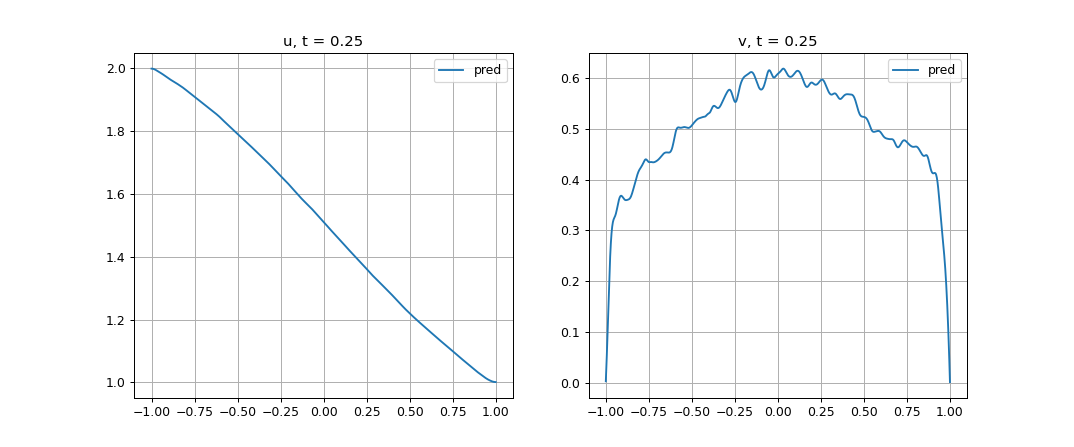

In [11]:
f, ax = plt.subplots(1, 2, figsize = (12, 5))
ax[0].plot(x_test, u_preds[-1], label = "pred")
ax[0].set_title("u, t = {}".format(t_test[-1]))
ax[1].plot(x_test, v_preds[-1], label = "pred")
ax[1].set_title("v, t = {}".format(t_test[-1]))
for i in range(2):
	ax[i].legend()
	ax[i].grid()
plt.show()

In [ ]:
# x = jnp.linspace(*domain[:, 0], 10000).reshape((-1, 1))
# t = jnp.zeros_like(x)
# xt = jnp.hstack([x, t])


# # direct_params_ = direct_params
# direct_params_ = get_params(opt_state)
# duv_dxt = jacobian(direct_params_, xt)
# du_dt, dv_dt = duv_dxt[:, 0:1, 1], duv_dxt[:, 1:2, 1]
# du_dx, dv_dx = duv_dxt[:, 0:1, 0], duv_dxt[:, 1:2, 0]
# duv_dxxtt = hessian(direct_params_, xt)
# du_dxx, dv_dxx = duv_dxxtt[:, 0:1, 0, 0], duv_dxxtt[:, 1:2, 0, 0] 
# uv = model(direct_params_, xt)
# u, v = uv[:, 0:1], uv[:, 1:2]
# loss_c1 = epsilon*du_dt + 0.5*epsilon**2*dv_dxx - V*v
# loss_c2 = epsilon*dv_dt - 0.5*epsilon**2*du_dxx + V*u

# du0_dx, dv0_dx = du0_dx_fn(xt), dv0_dx_fn(xt)
# du0_dxx, dv0_dxx = du0_dxx_fn(xt), dv0_dxx_fn(xt)
# u0, v0 = u0_fn(xt[:, 0:1], xt[:, 1:2]), v0_fn(xt[:, 0:1], xt[:, 1:2])
# du0_dt = 1.0/epsilon*(V*v0 - epsilon**2/2*dv0_dxx)
# dv0_dt = 1.0/epsilon*(epsilon**2/2*du0_dxx - V*u0)
# loss_c10 = epsilon*du0_dt + 0.5*epsilon**2*dv0_dxx - V*v0
# loss_c20 = epsilon*dv0_dt - 0.5*epsilon**2*du0_dxx + V*u0

# %matplotlib inline
# plt.rcParams.update(plt.rcParamsDefault)
# plt.rcParams["text.usetex"] = True

# f, ax = plt.subplots(2, 5, figsize = (20, 10))
# i, j = 0, 0
# ax[i][j].plot(x, du_dt, label = "pred")
# ax[i][j].plot(x, du0_dt, label = "true")
# ax[i][j].set_title(r"$\frac{\partial u}{\partial t}$")
# i = 1
# ax[i][j].plot(x, dv_dt, label = "pred")
# ax[i][j].plot(x, dv0_dt, label = "true")
# ax[i][j].set_title(r"$\frac{\partial v}{\partial t}$")
# i, j = 0, j+1
# ax[i][j].plot(x, du_dx, label = "pred")
# ax[i][j].plot(x, du0_dx, label = "true")
# ax[i][j].set_title(r"$\frac{\partial u}{\partial x}$")
# i = 1
# ax[i][j].plot(x, dv_dx, label = "pred")
# ax[i][j].plot(x, dv0_dx, label = "true")
# ax[i][j].set_title(r"$\frac{\partial v}{\partial x}$")
# i, j = 0, j+1
# ax[i][j].plot(x, du_dxx, label = "pred")
# ax[i][j].plot(x, du0_dxx, label = "true")
# ax[i][j].set_title(r"$\frac{\partial^2 u}{\partial x^2}$")
# i = 1
# ax[i][j].plot(x, dv_dxx, label = "pred")
# ax[i][j].plot(x, dv0_dxx, label = "true")
# ax[i][j].set_title(r"$\frac{\partial^2 v}{\partial x^2}$")
# i, j = 0, j+1
# ax[i][j].plot(x, u, label = "pred")
# ax[i][j].plot(x, u0, label = "true")
# ax[i][j].set_title(r"$u$")
# i = 1
# ax[i][j].plot(x, v, label = "pred")
# ax[i][j].plot(x, v0, label = "true")
# ax[i][j].set_title(r"$v$")
# i, j = 0, j+1
# ax[i][j].plot(x, loss_c1, label = "pred")
# ax[i][j].plot(x, loss_c10, label = "true")
# ax[i][j].set_title(r"loss c1")
# i = 1
# ax[i][j].plot(x, loss_c2, label = "pred")
# ax[i][j].plot(x, loss_c20, label = "true")
# ax[i][j].set_title(r"loss c2")

# for i in range(2):
# 	for j in range(5):
# 		ax[i][j].legend()
# 		ax[i][j].grid()
# plt.show()

In [ ]:
get_params(opt_state)

In [ ]:
du_dxx

In [ ]:
du0_dx_fn(jnp.array([[-0.25, 0.0], [0.25, 0.0]]))